In [73]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt


## Fundamental matrix estimation

For an introduction see https://docs.opencv.org/3.4/da/de9/tutorial_py_epipolar_geometry.html

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x7ff6a3e17f50>)

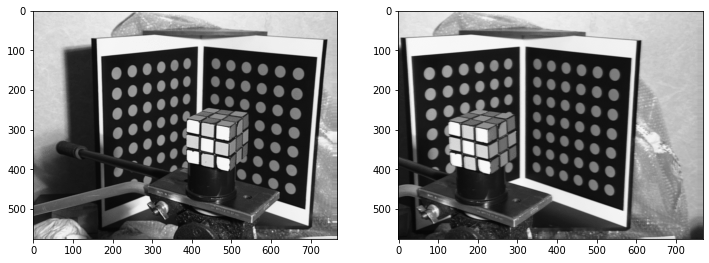

In [74]:
# you may try other image pairs
img1 = cv.imread('images/Rubik1.pgm', cv.IMREAD_GRAYSCALE)  
img2 = cv.imread('images/Rubik2.pgm', cv.IMREAD_GRAYSCALE)  
plt.figure(figsize=(12,6))
plt.subplot(121),plt.imshow(img1,cmap="gray") 
plt.subplot(122),plt.imshow(img2,cmap="gray")

In [75]:
# find the keypoints and descriptors with SIFT, then match them 
#(as done in lab2)

sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

pts1 = []
pts2 = []

bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
        
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [85]:
# estimate the fundamental matrix
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

We compute here the position of the epipoles

In [77]:
from scipy.linalg import null_space

el = null_space(F)
print(el)
er = null_space(F.T)
print(er)


[[-9.99814063e-01]
 [ 1.92829685e-02]
 [-7.45694416e-05]]
[[ 9.99899107e-01]
 [-1.42046311e-02]
 [ 7.22804268e-05]]


In [78]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [79]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.figure(figsize=(12,6))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()